In [110]:
from qaoa import QAOA, problems, mixers, initialstates

In [111]:
import numpy as np
import networkx as nx
import sys

sys.path.append("../")
from plotroutines import *

In this Exercise Notebook we are going to study the performance fo the QAOA on the maximum cut (MAXCUT) combinatorial optimization problem. The problem can stated as follows:

Consider a graph $G=(V,E)$ with nodes V, where $|V|=n$ and edges E with weights $w_{ij}>0,w_{ij}=w_{ji}$ for $(i,j)\in E$. A cut is defined as a partition of the original set V intop two subsets. the cost of this cut is the sum of weights of edges connecting points in the two different subsets. The MAXCUT is the cut that maximize this cost that can be defined as


$C(\vec{x})=\sum_{ij}w_{ij}x_{i}(1-x_{j})$. 

where $x_{i}$ is a binary variable that is 0 if the vertex is in the first partition or 1 if is in the second one.


Finding an exact solution for this problem is NP-hard but some classical algorithms can find an approximate solution in polynomial time like the Goemans-Williamson algorithm that guarantees an approximation ratio $\frac{C}{C_{opt}}=0.8785$.

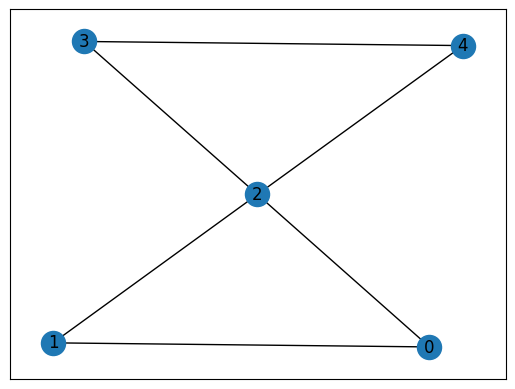

In [112]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, 5, 1))
G.add_weighted_edges_from(
    [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)]
)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)


# Exercise: construct a cost function that take in input a string and the graph problem and return the specific cost 

In [113]:
def cost(G, string):
        C = 0
        for edge in G.edges():
            i = int(edge[0])
            j = int(edge[1])
            if string[i] != string[j]:
                w = G[edge[0]][edge[1]]["weight"]
                C += w
        return C

Now we need to map the classical cost function into a Ising Hamiltonian called typically Problem Hamiltonian that encode the cost function in terms of spin variables (qubits). 

This can be done with the following transformation:

$x_{i}\rightarrow\frac{1-\sigma^{z}_{i}}{2}$



# Define The ZZ circuit using the Qiskit circuit and return the circuit operator to show them that they need that 

In [114]:
from qiskit.quantum_info import Operator

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

def ZZGate(theta):
    
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)

    qc.cx(qr[0], qr[1])
    qc.rz(theta, qr[1])
    qc.cx(qr[0], qr[1])

    return qc

print(Operator(ZZGate(np.pi/2)))

Operator([[0.70710678-0.70710678j, 0.        +0.j        ,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.70710678+0.70710678j,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.70710678+0.70710678j, 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.        +0.j        , 0.70710678-0.70710678j]],
         input_dims=(2, 2), output_dims=(2, 2))


# Quantum Alternating Operator Ansatz

The Quantum Ising Hamiltonian $H_{P}$, usually called in the QAOA formalism Phase or Problem Hamiltonian, is a diagonal operator that acts on the computational basis as:

$H_{P}\ket{x}=c(x)\ket{x}$

which means that the ground state is a computational basis state.

The QAOA ansatz consist of p layers of alternating two operators called respectively Mixer and Problem Operators. The ansatz wavefunction has the following form:

$\ket{\gamma,\beta}= \prod_{l=1}^{p}(U_{M}(\beta_{l})U_{P}(\gamma_{l}))\ket{\psi_{0}}$

where

$U_{M}$ is the Mixing operator that ensure transitions between all the possible feasible states


$U_{P}$ is the Phase Operator that has the form $U_{P}=e^{-i\gamma H_{P}}$

$\ket{\psi_{0}}$ is the initial state 


# Exercise: Construct the cost Hamiltonian Circuit 

In [115]:
def cost_circuit(G):
        """
        Adds a parameterized circuit for the cost part to the member variable self.parameteried_circuit
        and a parameter to the parameter list self.gamma_params
        """

        N_qubits=len(G.nodes)
        qr = QuantumRegister(N_qubits)
        qc= QuantumCircuit(qr)
        cost_param = Parameter("x_gamma")

        ### cost Hamiltonian
        for edge in G.edges():
            i = int(edge[0])
            j = int(edge[1])
            w = G[edge[0]][edge[1]]["weight"]
            wg = w * cost_param
            qc.append(ZZGate(wg),[qr[i],qr[j]])

        return qc

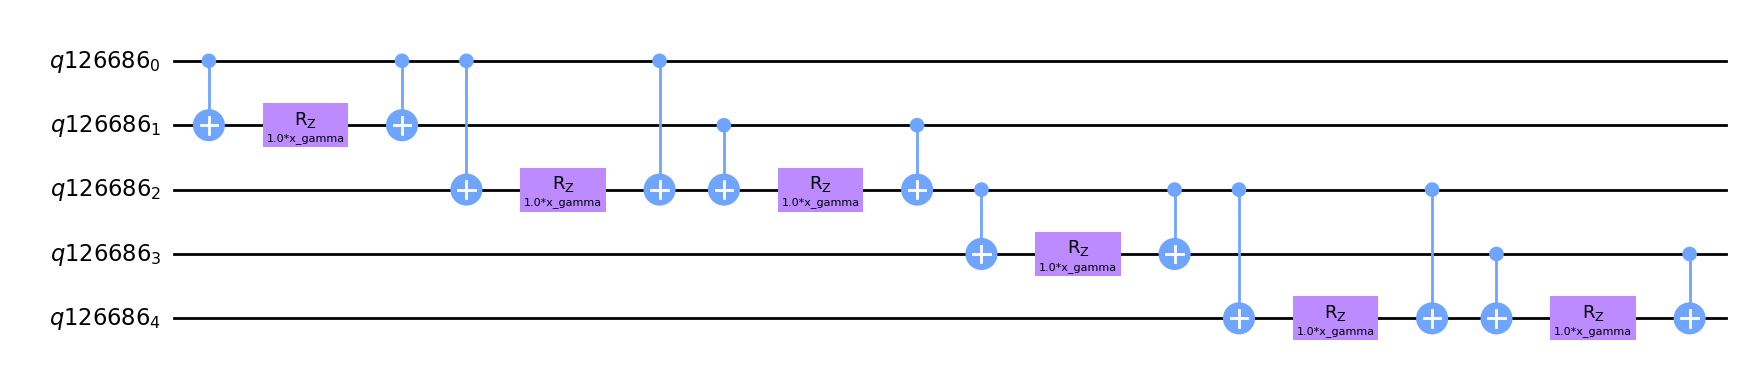

In [116]:
from qiskit.compiler import transpile
transpile(cost_circuit(G),basis_gates=['cx','rx','rz']).draw(output='mpl')

In the MAXCUT påroble the QAOA minimization is performed with respect to all states, so in particular in the whole n qubits Hilbert Space. For the standard QAOA the the mixing operator can be expressed as $U_{M}=e^{-i\beta{H_{M}}}, H_{M}=\sum_{i=1}^{N}\sigma^{x}_{i}$ and the initial state is the equal superposition of all the possible solutions $\ket{\psi_{0}}=\frac{1}{2^{N}}\sum_{i}\ket{i}=\ket{+}^{\otimes N}$ 

# Exercise: Implement the X mixer operator 

In [117]:
def X_mixer(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)

    mix_param=Parameter("x_beta")

    for i in range (N_qubits):
        qc.rx(mix_param,qr[i])

    return qc

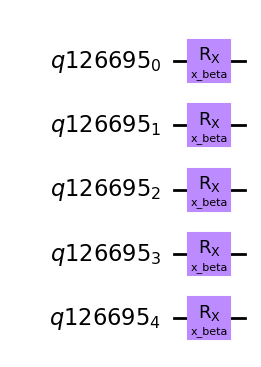

In [118]:
transpile(X_mixer(G),basis_gates=['cx','rx','rz']).draw(output='mpl')

# Exercise: Define a proper initial state for the problem

In [119]:
def initial_state_circuit(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)

    for i in range (N_qubits):
        qc.h(qr[i])
    
    return qc

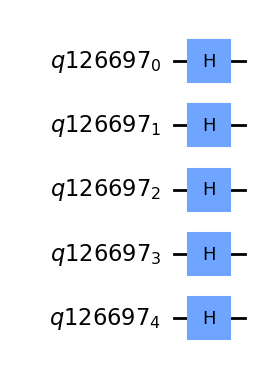

In [120]:
transpile(initial_state_circuit(G),basis_gates=['h','cx','rz','rx']).draw(output='mpl')

One we have defined the building blocks of our QAOA ansatz we can define an instance using the QAOA package to study the performances of the algorithm

In [121]:
qaoa = QAOA(
    initialstate=initialstates.Plus(), problem=problems.MaxCut(G=G), mixer=mixers.X()
)

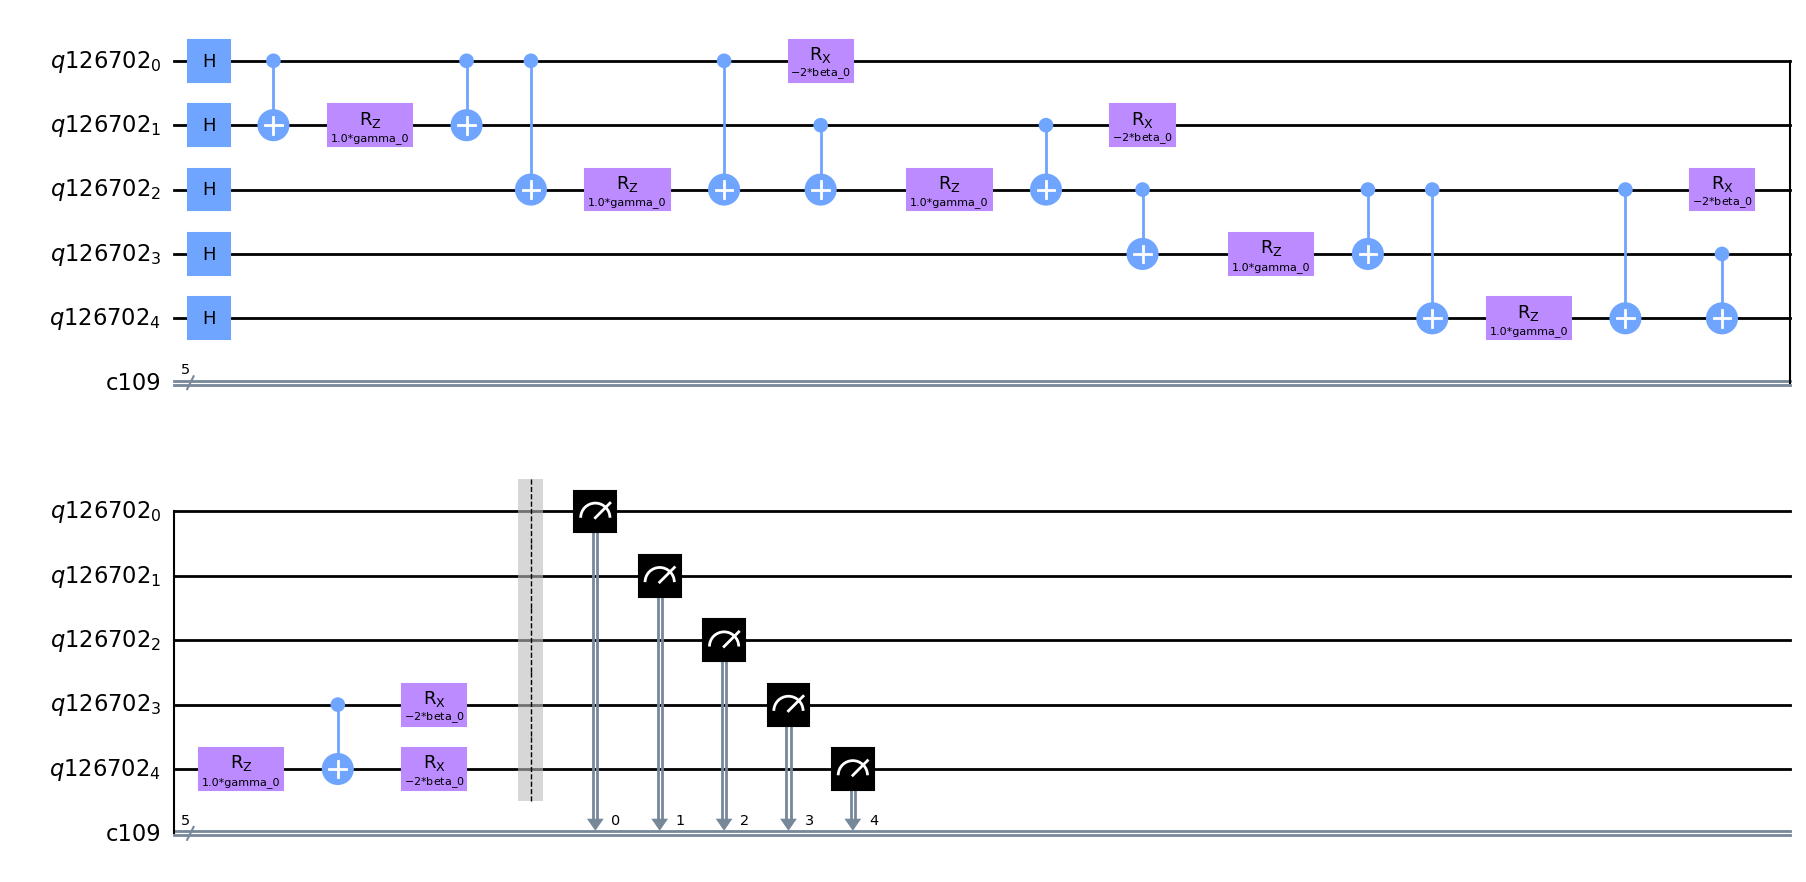

In [122]:
qaoa.createParameterizedCircuit(1)
qaoa.parameterized_circuit.draw(output="mpl")

In [123]:
'''
qaoa.initialstate=initial_state_circuit(G)
qaoa.problem.circuit=cost_circuit(G)
qaoa.mixer.circuit=X_mixer(G)
'''

'\nqaoa.initialstate=initial_state_circuit(G)\nqaoa.problem.circuit=cost_circuit(G)\nqaoa.mixer.circuit=X_mixer(G)\n'

For the case p=1 we can plot how the energy landscape looks like. This can help us to understand better how the optimization routine works. The energy landscape can be obtain just evaluating the energy associated to a certain couples of values $\gamma,\beta$ in a certain range. We know from construction that the energy in peridopdic in $\beta$ betqeen $[0,2\pi]$ and we want to explore the same range of values for the $\gamma$ parameter.

In the following cell we are going to plot the heatmap related to:

$\bra{\gamma,\beta}H\ket{\gamma,\beta}$, $\gamma,\beta\in[0,2\pi]$

2023-10-12 16:56:59 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:56:59 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:56:59 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:56:59 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:24 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:24 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


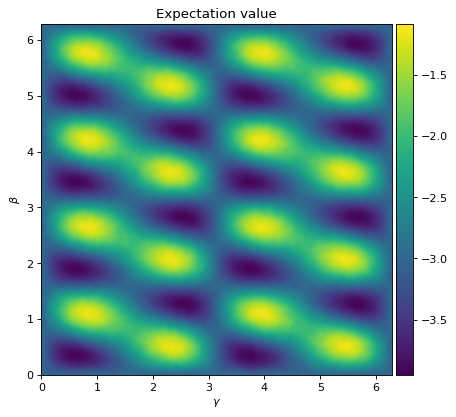

In [124]:
qaoa.sample_cost_landscape(
    angles={"gamma": [0, 2*np.pi , 100], "beta": [0, 2*np.pi, 100]}
)
plot_E(qaoa)

Calling the method optimize we can see how the optimization prodecure perform on the first layer of QAOA and understand from the prot of the landscape how we converge in one local minima

In [125]:
qaoa.optimize(depth=1)

2023-10-12 16:57:25 [info     ] cost(depth 1 = -3.8906249999999996 file=qaoa.qaoa func=optimize


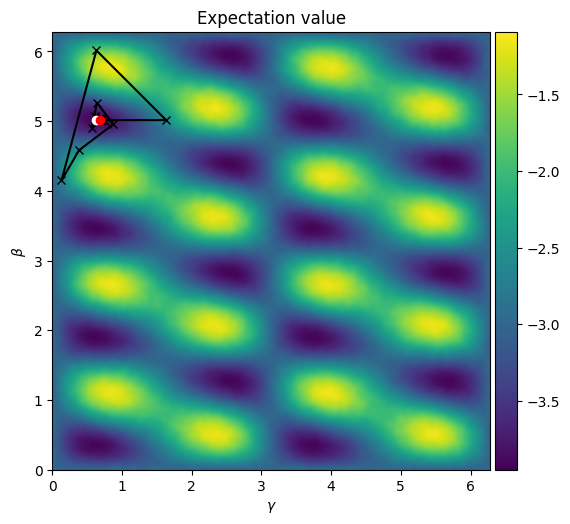

In [126]:
fig = pl.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
pl.plot(gamma, beta, "x-k")
pl.plot(gamma[0], beta[0], "wo")
pl.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa, fig=fig)

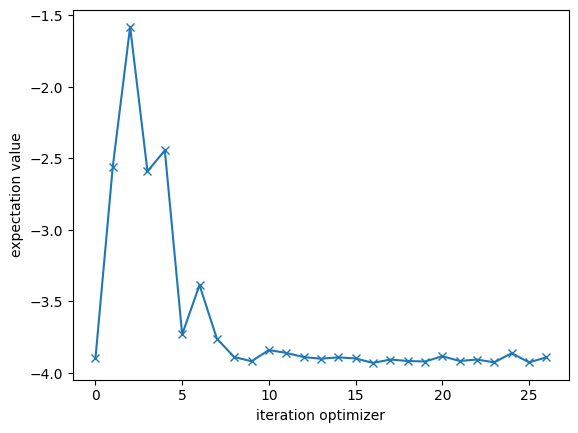

In [127]:
pl.plot(qaoa.optimization_results[1].Exp, "x-")
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")

In [128]:
min,max=qaoa.problem.computeMinMaxCosts()

# Classical Optimizer Analysis

One the most important ingredients of the QAOA algorithm, after the ansatz definition, is the choice of the classical optimizer to use to optimize the parameters at every iteration. Different types of optimizers can be used to optimize the cost function but there are three types in principle:

The Analitical gradients optimizers

The Stochastic Gradient Optimizers

The Gradient Free optimizers

In [129]:
from qiskit_algorithms.optimizers import SPSA, QNSPSA, COBYLA, NELDER_MEAD

In [130]:
optimizers = {}
plotstyle = {}

settings = {
    "maxiter": 70,
    "blocking": True,
    "allowed_increase": 0,
    "second_order": True,
    "regularization": 0.01,
}
optimizers["spsa"] = [SPSA, settings.copy()]
plotstyle["spsa"] = "+r"

settings = {
    "maxiter": 50,
    "blocking": True,
    "allowed_increase": 0,
    "learning_rate": 0.02,
    "perturbation": 0.05,
    "regularization": 0.01,
    "hessian_delay": 0,
}
optimizers["qnspsa"] = [QNSPSA, settings.copy()]
plotstyle["qnspsa"] = "og"

settings = {"maxiter": 100, "tol": 1e-6}
optimizers["neldermead"] = [NELDER_MEAD, settings.copy()]
plotstyle["neldermead"] = "xb"

settings = {"maxiter": 100, "tol": 1e-6}
optimizers["cobyla"] = [COBYLA, settings.copy()]
plotstyle["cobyla"] = "*k"

In [131]:
qaoa = {}
for key in optimizers:
    qaoa[key] = QAOA(
        initialstate=initialstates.Plus(),
        problem=problems.MaxCut(G=G),
        mixer=mixers.X(),
        optimizer=optimizers[key],
    )

In [132]:
maxdepth = 10
for key in optimizers:
    qaoa[key].optimize(depth=maxdepth)

2023-10-12 16:57:25 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-12 16:57:25 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:25 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:25 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:26 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:26 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2023-10-12 16:57:29 [info     ] cost(depth 1 = -3.92578125     file=qaoa.qaoa func=optimize
2023-10-12 16:57:31 [info     ] cost(depth 2 = -3.933593749999999 file=qaoa.qaoa func=optimize
2023-10-12 16:57:36 [info     ] cost(depth 3 = -3.96875        file=qaoa.qaoa func=optimize
2023-10-12 16:57:41 [info     ] cost(depth 4 = -4.0            file=

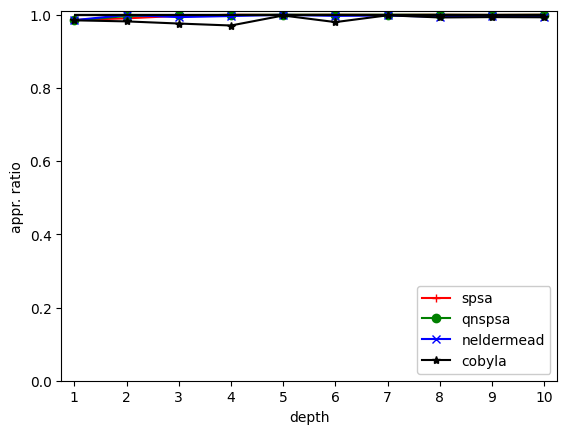

In [133]:
fig = pl.figure()
for key in optimizers:
    plot_ApproximationRatio(
        qaoa[key],
        maxdepth,
        mincost=min,
        maxcost=0,
        label=key,
        style=plotstyle[key] + "-",
        fig=fig,
    )

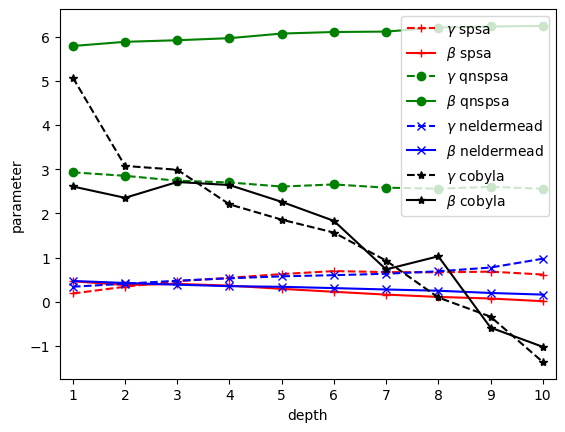

In [134]:
p = maxdepth
fig = pl.figure(p)

for key in optimizers:
    plot_angles(qaoa[key], p, label=key, style=plotstyle[key], fig=fig)